# Task 1 : Generative Classification approach (QDA model)

In [29]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.decomposition import PCA
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
warnings.filterwarnings("ignore")

## Extracting features using EfficientNet B4

We first used pre-trained EfficientNet B4 model to extract relevant features. We stored this datasets for future use. 

Download them from here - https://github.com/AshwinBarnwal/CS771-mini-project-2.

In [ ]:
#LOADING DATASETS

path = r"C:\Users\there\Desktop\Code\dataset\part_one_dataset"
path2 = r"C:\Users\there\Desktop\Code\dataset\part_two_dataset"

traindata = [torch.load(f"{path}\\train_data\\{i}_train_data.tar.pth", map_location=torch.device('cpu')) for i in range(1, 11)]+[torch.load(f"{path2}\\train_data\\{i}_train_data.tar.pth", map_location=torch.device('cpu')) for i in range(1, 11)]
evaldata = [torch.load(f"{path}\\eval_data\\{i}_eval_data.tar.pth", map_location=torch.device('cpu')) for i in range(1, 11)]+[torch.load(f"{path2}\\eval_data\\{i}_eval_data.tar.pth", map_location=torch.device('cpu')) for i in range(1, 11)]

In [ ]:
# Load the pretrained model
model = models.efficientnet_b4(pretrained=True)

# Remove the last fully connected layer
# Replace it with an identity layer to output the raw features
model.fc = nn.Identity()

# Set model to evaluation mode
model.eval()

In [30]:
#DEFINING WRAPPER FUNCTION FOR FEATURE EXTRACTION

def process_batch(batch, model, preprocess):
    batch_tensors = []
    for img_array in batch:
        # Convert numpy array to torch.Tensor and process as before
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1).float() / 255.0  # Shape: [C, H, W]
        
        # Apply any additional preprocessing transformations if needed
        img_tensor = preprocess(img_tensor)
        
        # Add batch dimension (resulting in shape: [1, C, H, W])
        batch_tensors.append(img_tensor.unsqueeze(0))

    # Stack batch tensors along the batch dimension (shape: [batch_size, C, H, W])
    batch_tensor = torch.cat(batch_tensors, dim=0)
    
    # Extract features for the batch
    with torch.no_grad():  # Disable gradient computation
        batch_features = model(batch_tensor)  # Forward pass
    return batch_features



def extract(traindata):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformations to the image
    # Example usage
    
    X = traindata['data']
    

    X_effnet = []
    batch_size = 64  # Choose a batch size that fits your memory requirements
    #model.eval()  # Set the model to evaluation mode

    # Process data in batches
    for i in range(0, len(X), batch_size):
        batch = X[i:i + batch_size]  # Slice out a batch from X
        batch_features = process_batch(batch, model, preprocess)  # Process batch
        X_effnet.append(batch_features)  # Collect the batch features

    # Concatenate all batch features to form the final feature matrix
    X_effnet = torch.cat(X_resnet, dim=0)
    return X_effnet

In [ ]:
for i in range(20):
    train=extract(traindata[i])
    torch.save(train, f"extracted_data\X_train_{i+1}.pth")
for i in range(20):
    eval=extract(evaldata[i])
    torch.save(eval, f"EffNet_sets_data\X_eval_{i+1}.pth")

## Exploring the dataset

We load in the first dataset.

In [6]:
traindata_1 = torch.load(r"C:\Users\ARITRA\Documents\Notebooks\CS771_MiniProject2\dataset\dataset\part_one_dataset\train_data\1_train_data.tar.pth")
X = torch.load(r"train_data_1_resnet.pt")
y = traindata_1['targets']

In [7]:
X.shape

torch.Size([2500, 2048])

In [8]:
y.shape

(2500,)

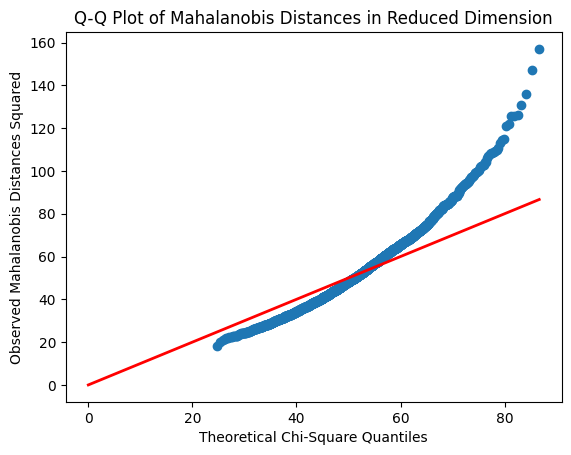

In [14]:
# Step 1: Dimensionality Reduction
data = X
pca = PCA(n_components=50)  # Reduce to 50 dimensions (or another chosen number)
reduced_data = pca.fit_transform(data)

# Step 2: Calculate Mahalanobis Distances in Reduced Dimension
mean = np.mean(reduced_data, axis=0)
cov = np.cov(reduced_data, rowvar=False)
inv_cov = np.linalg.inv(cov)
mahalanobis_dists = [np.sqrt((x - mean).T @ inv_cov @ (x - mean)) for x in reduced_data]

# Step 3: Plot Q-Q Plot for Mahalanobis Distances
chi2_quantiles = chi2.ppf(np.linspace(0.001, 0.999, len(mahalanobis_dists)), df=50)
plt.plot(np.sort(chi2_quantiles), np.sort(np.square(mahalanobis_dists)), 'o')
plt.plot([0, max(chi2_quantiles)], [0, max(chi2_quantiles)], color='r', lw=2)
plt.xlabel("Theoretical Chi-Square Quantiles")
plt.ylabel("Observed Mahalanobis Distances Squared")
plt.title("Q-Q Plot of Mahalanobis Distances in Reduced Dimension")
plt.show()

This shows our data is deviating a lot from Gaussian.

So we convert it into a Gaussian with mean 0 and SD 1, as we are later going to use generative classification based approaches with Gaussian modelling.

In [ ]:
data = X
# Apply Standard Scaling
scaler = StandardScaler()
standardized_data = scaler.fit_transform(data)  # Shape: (n_samples, 2048)

# Apply Yeo-Johnson transformation to convert skewed distribution to Gaussian
transformer = PowerTransformer(method='yeo-johnson')
yeo_johnson_data = transformer.fit_transform(standardized_data)  # Shape: (n_samples, 2048)
from sklearn.decomposition import PCA

# Perform PCA on the transformed data to obtain independent components
pca = PCA(n_components=50)  # Keep full dimensionality (or reduce if necessary)
pca_data_before = pca.fit_transform(yeo_johnson_data)  # Shape: (n_samples, 2048)

# Standardize the PCA-transformed data to mean 0 and standard deviation 1
pca_data = (pca_data_before - np.mean(pca_data_before, axis=0)) / np.std(pca_data_before, axis=0)

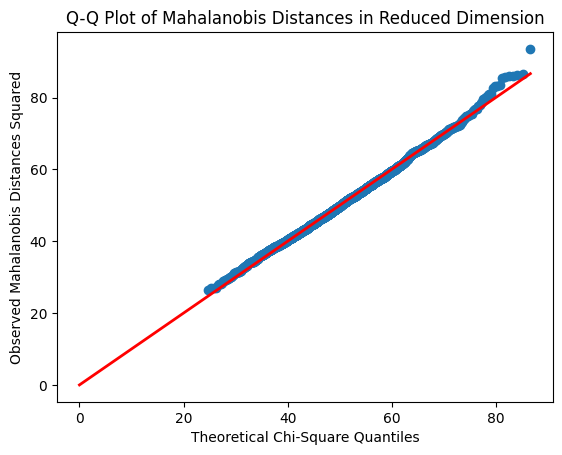

In [16]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import chi2
import matplotlib.pyplot as plt

# Assuming 'data' is your high-dimensional dataset
# Step 1: Dimensionality Reduction
"""data = X
pca = PCA(n_components=50)  # Reduce to 50 dimensions (or another chosen number)"""
reduced_data = pca_data

# Step 2: Calculate Mahalanobis Distances in Reduced Dimension
mean = np.mean(reduced_data, axis=0)
cov = np.cov(reduced_data, rowvar=False)
inv_cov = np.linalg.inv(cov)
mahalanobis_dists = [np.sqrt((x - mean).T @ inv_cov @ (x - mean)) for x in reduced_data]

# Step 3: Plot Q-Q Plot for Mahalanobis Distances
chi2_quantiles = chi2.ppf(np.linspace(0.001, 0.999, len(mahalanobis_dists)), df=50)
plt.plot(np.sort(chi2_quantiles), np.sort(np.square(mahalanobis_dists)), 'o')
plt.plot([0, max(chi2_quantiles)], [0, max(chi2_quantiles)], color='r', lw=2)
plt.xlabel("Theoretical Chi-Square Quantiles")
plt.ylabel("Observed Mahalanobis Distances Squared")
plt.title("Q-Q Plot of Mahalanobis Distances in Reduced Dimension")
plt.show()

We can see our data now closely fits with the Gaussian distribution.

## Preprocessing our data

This is our preprocessing pipeline.

In [19]:
class PreprocessingPipeline:
    def __init__(self, n_components=50):
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer(method='yeo-johnson')
        self.pca = PCA(n_components=n_components)
        self.pca_mean = None
        self.pca_std = None

    def fit_transform(self, X_train):
        """
        Fits the preprocessing pipeline on the training set and applies transformations.
        
        Parameters:
n: ndarray of shape (n_samples, n_features), training data.
        
        Returns:
        - pca_train: Preprocessed training data.
        """
        # Step 1: Standardization
        standardized_train = self.scaler.fit_transform(X_train)

        # Step 2: Yeo-Johnson Transformation
        transformed_train = self.transformer.fit_transform(standardized_train)

        # Step 3: PCA
        pca_train = self.pca.fit_transform(transformed_train)

        # Step 4: Standardize PCA-transformed data
        self.pca_mean = np.mean(pca_train, axis=0)
        self.pca_std = np.std(pca_train, axis=0)
        pca_train_standardized = (pca_train - self.pca_mean) / self.pca_std

        return pca_train_standardized

    def transform(self, X):
        """
        Applies the fitted preprocessing pipeline to new data.

        Parameters:
        - X: ndarray of shape (n_samples, n_features), data to preprocess.
        
        Returns:
        - pca_transformed: Preprocessed data.
        """
        # Step 1: Standardization
        standardized = self.scaler.transform(X)

        # Step 2: Yeo-Johnson Transformation
        transformed = self.transformer.transform(standardized)

        # Step 3: PCA
        pca_transformed = self.pca.transform(transformed)

        # Step 4: Standardize PCA-transformed data using training set stats
        pca_transformed_standardized = (pca_transformed - self.pca_mean) / self.pca_std

        return pca_transformed_standardized


We prepare all our training and evaluation datasets next.

In [24]:
path = r"C:\Users\ARITRA\Documents\Notebooks\CS771_MiniProject2\dataset\dataset\part_one_dataset"

traindata_1 = torch.load(f"{path}\\train_data\\1_train_data.tar.pth", map_location=torch.device('cpu'))
y_train_1 = traindata_1['targets']

evaldata = [torch.load(f"{path}\\eval_data\\{i}_eval_data.tar.pth", map_location=torch.device('cpu')) for i in range(1, 11)]
y_test=[i['targets'] for i in evaldata]

pipeline=PreprocessingPipeline()

X_train=[pipeline.fit_transform(torch.load('extracted_data/X_train_1.pth'))]+[pipeline.transform(torch.load(f'extracted_data/X_train_{i}.pth')) for i in range(2,11)]
X_eval=[pipeline.transform(torch.load(f'extracted_data/X_eval_{i}.pth')) for i in range(1,11)]

## Our Model

We are using a generative classification model (the probabilistic counterpart of LwP). Specifically we are using the Quadratic Discriminant Analysis model.

In [22]:
import numpy as np
from scipy.stats import multivariate_normal

class QDAClassifier:
    def __init__(self):
        self.class_means = {}
        self.class_covariances = {}
        self.class_priors = {}
        self.class_counts = {}
        self.total_samples = 0
    
    def fit(self, X, y): # For getting the means, covariances and class priors from our initial training data
        """
        Fits the QDA model to the data.

        Parameters:
        - X: ndarray of shape (n_samples, n_features), training data
        - y: ndarray of shape (n_samples,), class labels
        """
        self.total_samples = X.shape[0]
        classes = np.unique(y)
        
        for c in classes:
            # Get data points belonging to class c
            class_data = X[y == c]
            class_count = class_data.shape[0]
            
            # Compute class-specific statistics
            self.class_means[c] = np.mean(class_data, axis=0)
            self.class_covariances[c] = np.cov(class_data, rowvar=False)
            self.class_priors[c] = class_count / self.total_samples
            self.class_counts[c] = class_count

    def predict(self, X): #Predicting the class of test examples by computing posterior
        """
        Predict the class labels for a dataset X.
    
        Parameters:
        - X: ndarray of shape (n_samples, n_features), the input data matrix.
    
        Returns:
        - predictions: ndarray of shape (n_samples,), the predicted class labels for each sample.
        """
        n_samples = X.shape[0]
        predictions = np.zeros(n_samples, dtype=int)  # Initialize predictions array
        
        # Get the classes from the keys of class_means
        classes = list(self.class_means.keys())
    
        for i in range(n_samples):
            posteriors = []
            for c in classes:
                # Compute likelihood P(x | y = c) using the multivariate Gaussian PDF
                mean = self.class_means[c]
                cov = self.class_covariances[c]
                prior = self.class_priors[c]
                likelihood = multivariate_normal.pdf(X[i], mean=mean, cov=cov)
    
                # Compute posterior P(y = c | x) = P(x | y = c) * P(y = c)
                posterior = likelihood * prior
                posteriors.append(posterior)
            
            # Predict the class with the highest posterior
            predictions[i] = classes[np.argmax(posteriors)]
        
        return predictions
    
    def get_class_statistics(self): #Getting the current stored mean, covariance and prior for each class
        """
        Returns the learned statistics for each class.
        
        Returns:
        - class_means: dict of class means
        - class_covariances: dict of class covariance matrices
        - class_priors: dict of class priors
        - class_counts: dict of the number of samples per class
        """
        return {
            'means': self.class_means,
            'covariances': self.class_covariances,
            'priors': self.class_priors,
            'counts': self.class_counts,
        }
        
    def update(self, X): # For updating model f_i to f_i+1, by first predicting labels of unlabelled dataset, then training on this new dataset, and
                         # finally updating the model parameters by weighted average - taking into account the no. of training examples seen till now  
                         # and the no. of new test examples.
    # Step 2: Predict labels
        predicted_labels = self.predict(X)
    
    # Step 3: Update statistics per class
        for c in self.class_means.keys():
            # Get new samples for class c
            new_samples = X[predicted_labels == c]
            new_count = new_samples.shape[0]
            if new_count == 0:
                continue  # No new samples for this class
        
            # Update mean
            current_mean = self.class_means[c]
            current_count = self.class_counts[c]
            new_mean = (current_mean * current_count + new_samples.sum(axis=0)) / (current_count + new_count)
        
            # Update covariance
            current_cov = self.class_covariances[c]
            scatter_current = current_cov * current_count
            scatter_new = np.cov(new_samples, rowvar=False) * new_count
            scatter_updated = scatter_current + scatter_new
            updated_cov = scatter_updated / (current_count + new_count)
        
        # Update priors, counts, etc.
            self.class_means[c] = new_mean
            self.class_covariances[c] = updated_cov
            self.class_counts[c] += new_count
            self.class_priors[c] = self.class_counts[c] / self.total_samples

    # Update total sample count
        self.total_samples += X.shape[0]

     def mod_update(self, X, h): #This is used exclusively in Task 2, will be explained there
        predicted_labels = self.predict(X)
        for c in self.class_means.keys():
            # Get new samples for class c
            new_samples = X[predicted_labels == c]
            new_count = new_samples.shape[0]
            if new_count == 0:
                continue  # No new samples for this class
        
            # Update mean
            current_mean = self.class_means[c]
            # current_count = self.class_counts[c]
            new_mean = current_mean *(1-h) + (h)*new_samples.sum(axis=0)/new_count
        
            # Update covariance
            current_cov = self.class_covariances[c]
            scatter_current = current_cov * (1-h)
            scatter_new = np.cov(new_samples, rowvar=False) * h
            scatter_updated = scatter_current + scatter_new
            updated_cov = scatter_updated
        
        # Update priors, counts, etc.
            self.class_means[c] = new_mean
            self.class_covariances[c] = updated_cov
            self.class_priors[c] = self.class_counts[c]*(1-h) + new_count*h
            self.class_counts[c] += new_count

Next we train the generative LwP model on the labelled dataset 1. Then we subsequently use the update function which a) generates predicted labels for each successive dataset and b) updates all the parameters - mean, covariance and class priors in a weighted fashion, using number of past examples and number of new examples as weights.

In [25]:
import pickle
qda=QDAClassifier()
qda.fit(X_train[0], y_train_1)
pickle.dump(qda, open(f"f1_qda.pkl", "wb"))
print("done 1")
for i in range(1,10):
    qda.update(X_train[i])
    pickle.dump(qda, open(f"f{i+1}_qda.pkl","wb"))
    print(f"done {i+1}")

done 1
done 2
done 3
done 4
done 5
done 6
done 7
done 8
done 9
done 10


In [26]:
model_list=[pickle.load(open(f'f{i+1}_qda.pkl','rb')) for i in range(10)]

accuracies=np.zeros((10,10))
for i in range(10):
    for j in range(i+1):
        prediction=model_list[i].predict(X_eval[j])
        accuracies[i][j]=np.mean(prediction == y_test[j])*100

print(accuracies)
with open('accuracies1.pkl', 'wb') as f:
    pickle.dump(accuracies, f)

[[85.88  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [84.96 85.8   0.    0.    0.    0.    0.    0.    0.    0.  ]
 [84.24 85.6  85.04  0.    0.    0.    0.    0.    0.    0.  ]
 [83.8  85.4  84.24 84.28  0.    0.    0.    0.    0.    0.  ]
 [83.52 85.4  84.04 83.52 84.4   0.    0.    0.    0.    0.  ]
 [83.24 84.72 83.4  83.44 84.2  85.2   0.    0.    0.    0.  ]
 [83.2  84.56 83.44 83.12 84.04 84.8  83.08  0.    0.    0.  ]
 [83.16 84.12 82.92 82.88 83.64 84.36 82.6  84.08  0.    0.  ]
 [82.96 84.08 82.64 82.84 83.44 84.2  82.6  83.88 82.72  0.  ]
 [82.84 84.04 82.52 82.72 83.32 83.8  82.44 83.64 82.72 83.8 ]]


This is the matrix of the accuracies obtained.